In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt

from wrightdistribution import (
    wright,
    wright_mean,
    wright_pdf,
    wright_sfs,
    wright_var,
)

import scienceplots
plt.style.use("science")

# The Wright Distribution

*Disclaimer: this notebook was generated by an LLM*

The **Wright distribution** describes the stationary distribution of allele frequencies in a finite population under the combined effects of mutation, selection, and genetic drift. Its unnormalised density on $[0, 1]$ is:

$$
f(p) \propto p^{2N\alpha - 1} \cdot (1-p)^{2N\beta - 1}
\cdot \exp\!\bigl(-Ns \cdot p \cdot (2h + (1-2h)(2-p))\bigr)
$$

where:
- $p$ is the allele frequency
- $Ns$ is the scaled selection coefficient
- $N\alpha$, $N\beta$ are the scaled mutation rates
- $h$ is the dominance coefficient

This implementation uses **JAX** with Gauss-Jacobi quadrature, making it fully differentiable via `jax.grad`.

In [2]:
Ns = -20
Na = 1.0 
Nb = 1.0 
h = 0.05 
jnp.hstack([Ns, Na, Nb, h])

Array([-20.  ,   1.  ,   1.  ,   0.05], dtype=float64, weak_type=True)

In [3]:
d = wright(Ns, Na, Nb, h)
ps = jnp.linspace(0.001, 0.999, 500)
density = jax.vmap(lambda p: wright_pdf(d, p))(ps)

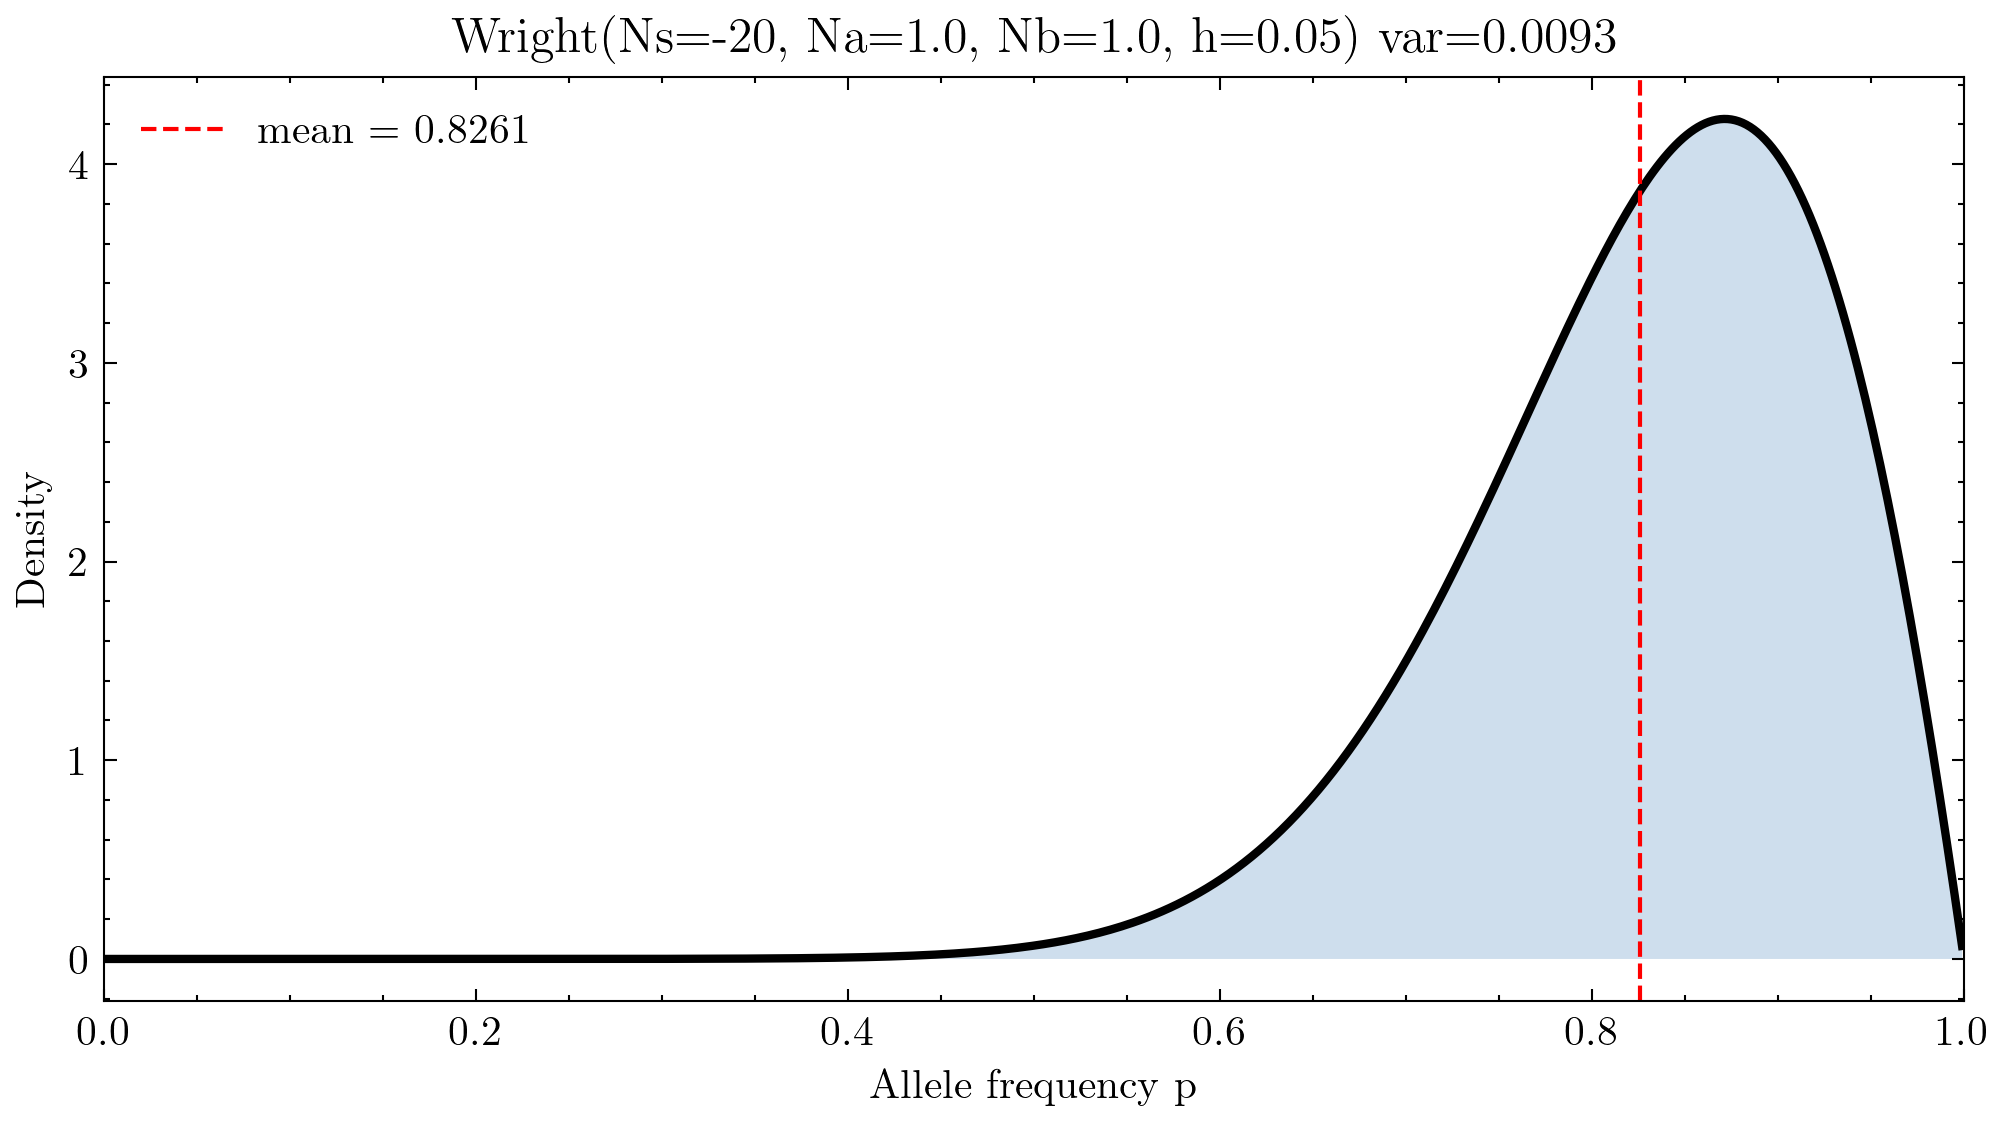

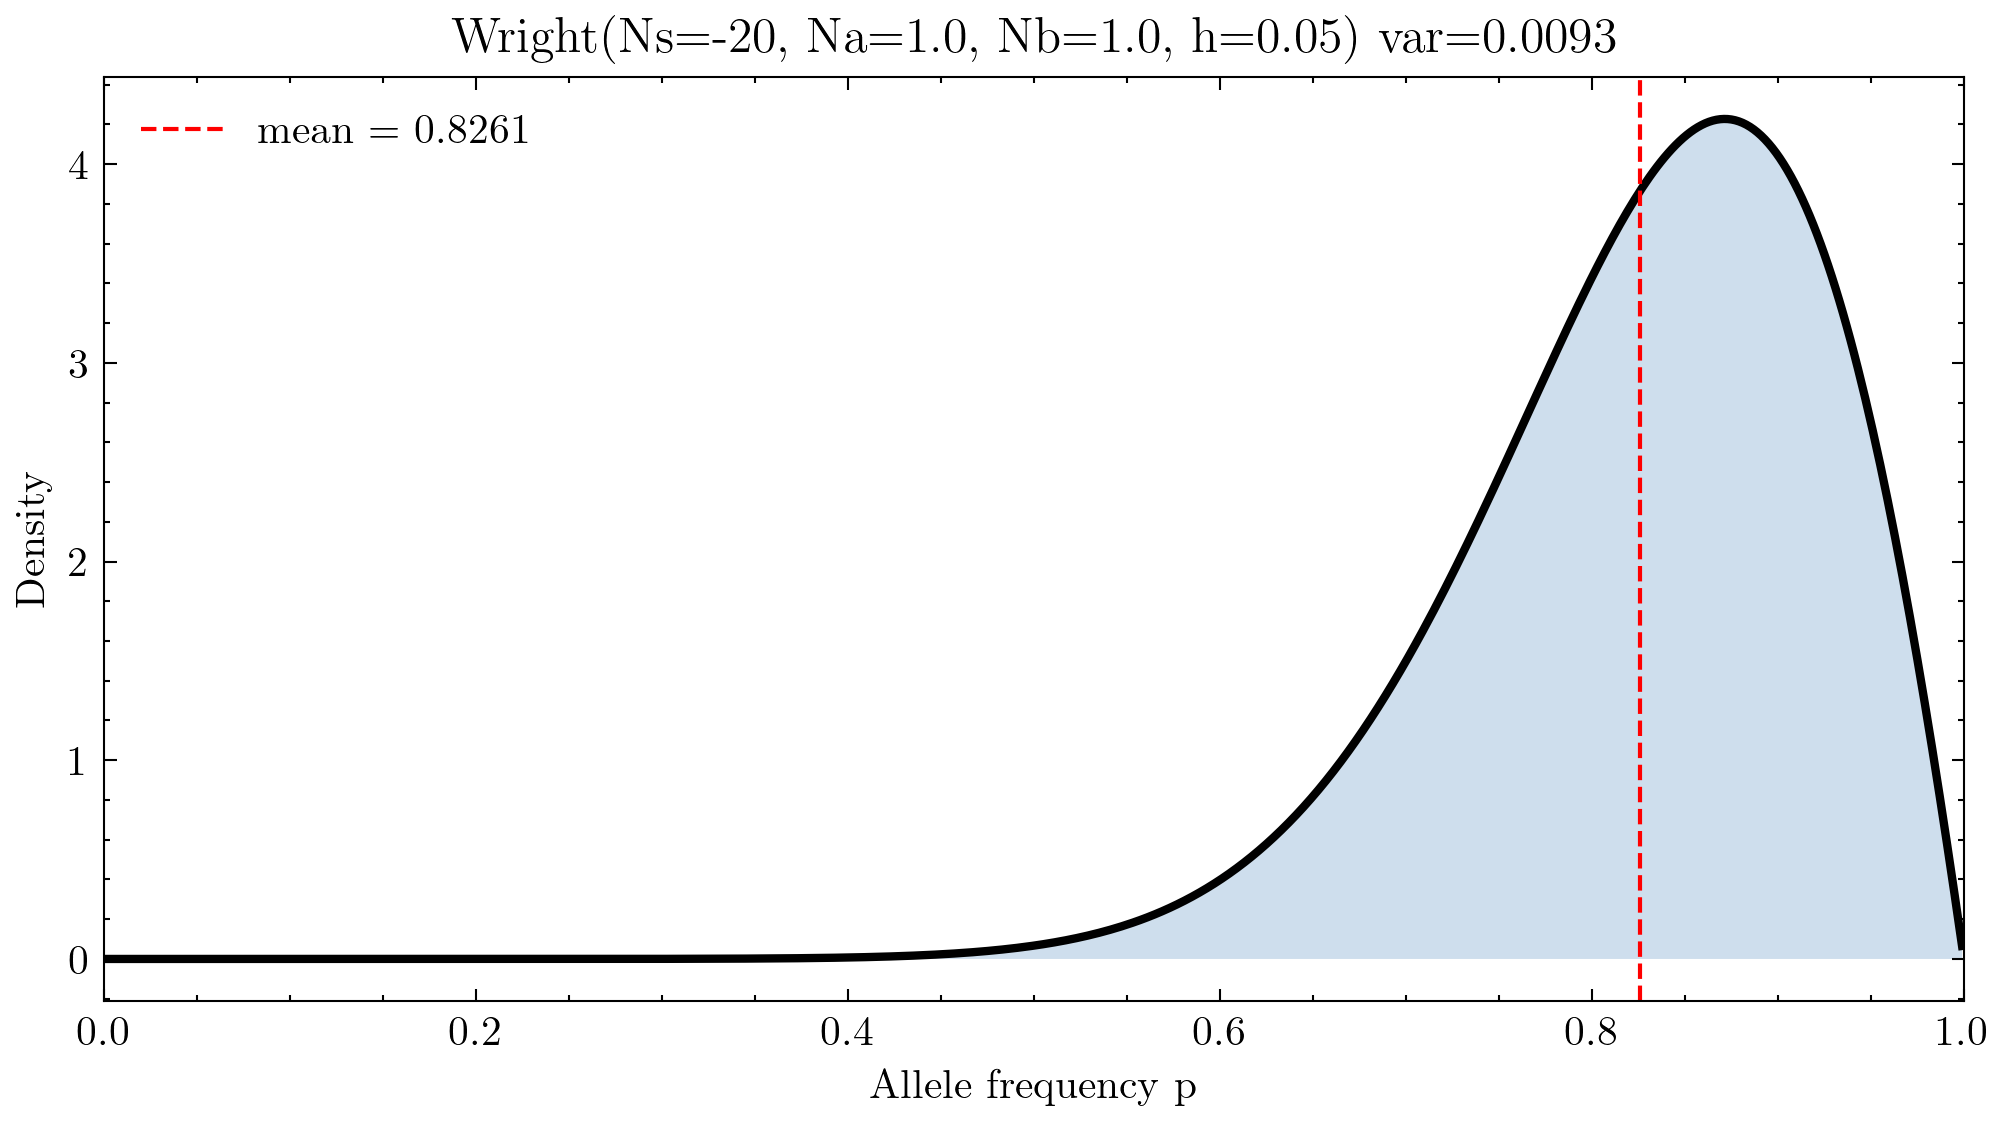

In [4]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
ax.plot(ps, density, "k-", lw=2)
ax.fill_between(ps, density, alpha=0.2)
m = float(wright_mean(d))
ax.axvline(m, color="red", ls="--", label=f"mean = {m:.4f}")
v = float(wright_var(d))
ax.set_xlabel("Allele frequency p")
ax.set_ylabel("Density")
ax.set_title(
    f"Wright(Ns={Ns}, Na={Na}, "
    f"Nb={Nb}, h={h})  "
    f"var={v:.4f}"
)
ax.legend()
ax.set_xlim(0, 1)
fig

## Special cases

### 1. Neutral evolution ($Ns = 0$)

When there is no selection, the Wright distribution reduces to a
**Beta distribution** $\mathrm{Beta}(2N\alpha, 2N\beta)$.
The mean allele frequency is $\alpha / (\alpha + \beta)$.

### 2. Mutation-selection balance

Under strong selection against an allele ($Ns \ll 0$),
the equilibrium frequency satisfies $q \approx u/s$
(the classical mutation-selection balance result).

### 3. Dominance

The parameter $h$ controls dominance:
- $h = 0.5$: additive (co-dominant) selection
- $h = 0$: the selected allele is fully recessive
- $h = 1$: the selected allele is fully dominant

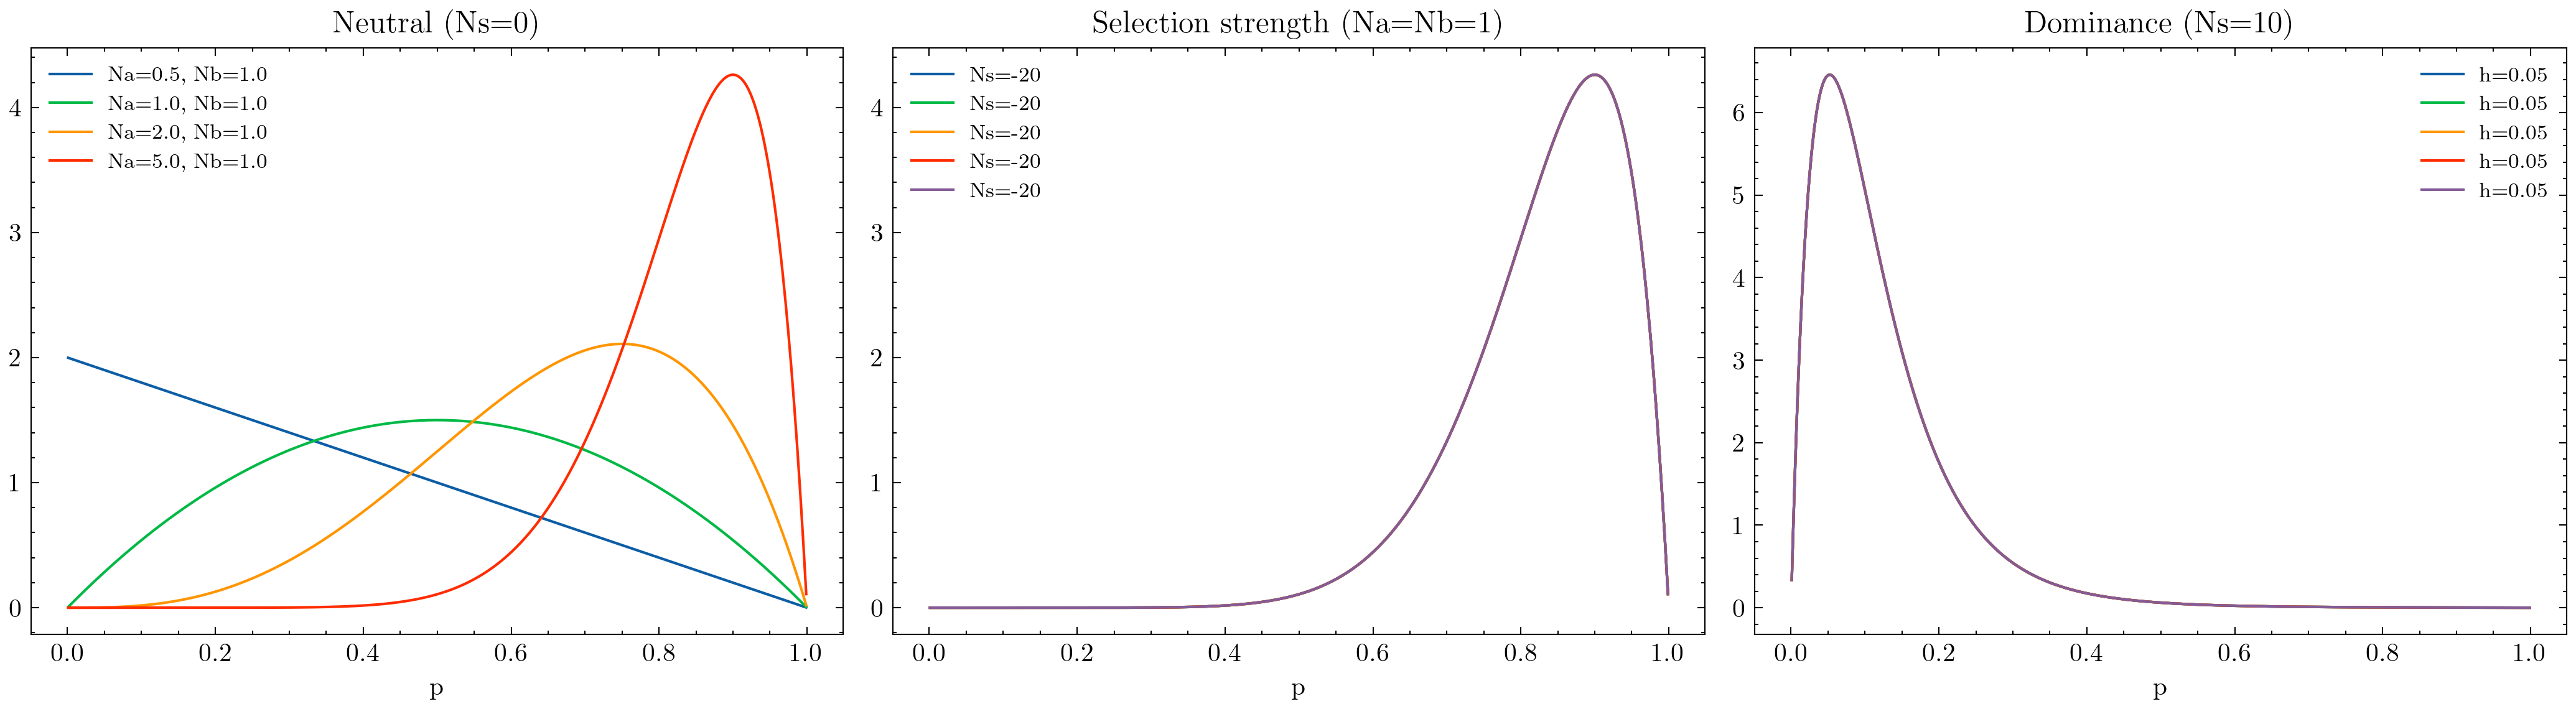

In [5]:
ps = jnp.linspace(0.001, 0.999, 500)
fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=300)

# Neutral
ax = axes[0]
for Na, _Nb in [(0.5, 0.5), (1.0, 1.0), (2.0, 1.0), (5.0, 2.0)]:
    d = wright(0.0, Na, Nb, 0.5)
    density = jax.vmap(lambda p, d=d: wright_pdf(d, p))(ps)
    ax.plot(ps, density, label=f"Na={Na}, Nb={Nb}")
ax.set_title("Neutral (Ns=0)")
ax.set_xlabel("p")
ax.legend(fontsize=8)

# Selection strength
_ax = axes[1]
for _Ns in [0.0, 5.0, 20.0, -5.0, -20.0]:
    _d = wright(Ns, 1.0, 1.0, 0.5)
    _density = jax.vmap(lambda p, d=d: wright_pdf(d, p))(ps)
    _ax.plot(ps, density, label=f"Ns={Ns}")
_ax.set_title("Selection strength (Na=Nb=1)")
_ax.set_xlabel("p")
_ax.legend(fontsize=8)

# Dominance
ax = axes[2]
for _h in [0.0, 0.25, 0.5, 0.75, 1.0]:
    d = wright(10.0, 1.0, 1.0, h)
    density = jax.vmap(lambda p, d=d: wright_pdf(d, p))(ps)
    ax.plot(ps, density, label=f"h={h}")
ax.set_title("Dominance (Ns=10)")
ax.set_xlabel("p")
ax.legend(fontsize=8)

plt.tight_layout()

## Automatic Differentiation

Because the implementation uses JAX with differentiable Gauss-Jacobi
quadrature (via the Golub-Welsch algorithm), we can compute gradients
of **any** quantity with respect to **any** parameter.

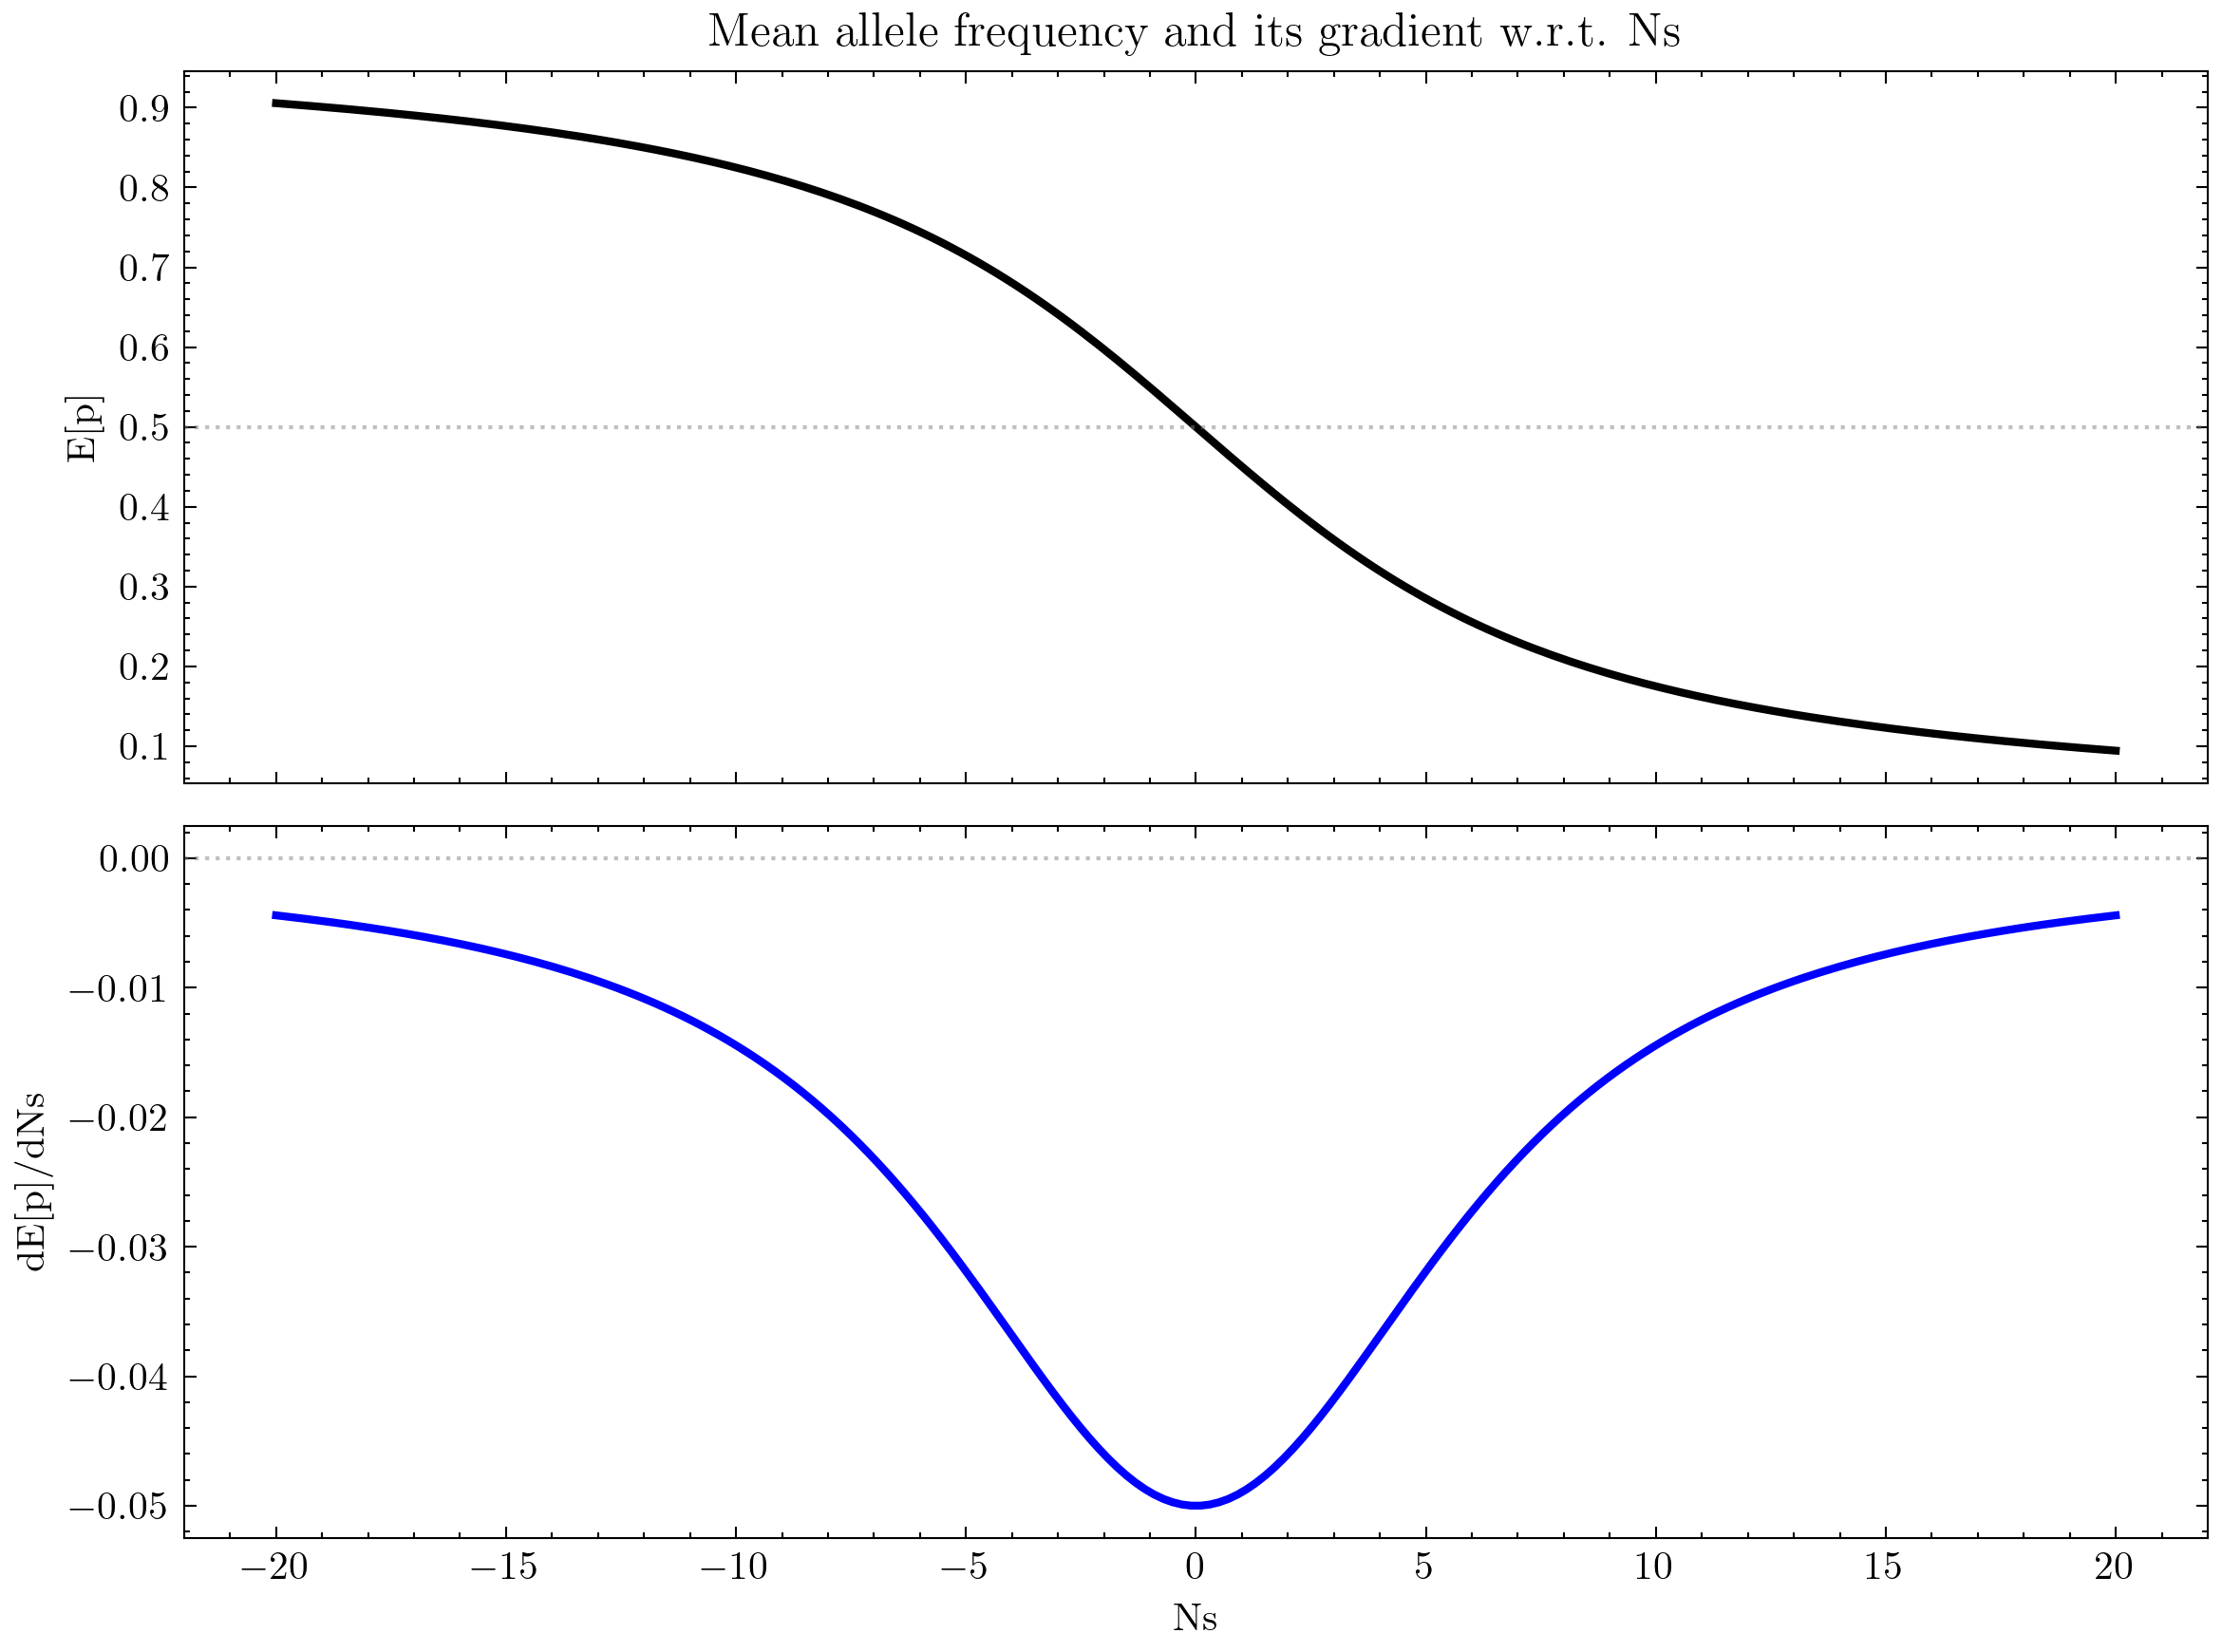

In [6]:
Ns_range = jnp.linspace(-20.0, 20.0, 200)

def mean_of_Ns(Ns):
    d = wright(Ns, 1.0, 1.0, 0.5)
    return wright_mean(d)

grad_mean = jax.vmap(jax.grad(mean_of_Ns))(Ns_range)
means = jax.vmap(mean_of_Ns)(Ns_range)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, dpi=300)

ax1.plot(Ns_range, means, "k-", lw=2)
ax1.set_ylabel("E[p]")
ax1.set_title("Mean allele frequency and its gradient w.r.t. Ns")
ax1.axhline(0.5, color="gray", ls=":", alpha=0.5)

ax2.plot(Ns_range, grad_mean, "b-", lw=2)
ax2.set_xlabel("Ns")
ax2.set_ylabel("dE[p]/dNs")
ax2.axhline(0, color="gray", ls=":", alpha=0.5)

plt.tight_layout()